# Simulation  of a PSK Transmission over AWGN Channels

## Table of Contents

* [System Model](#SystemModel)
* [Analysis of 16-PSK](#Analysis16PSK)


## System Model <a class="anchor" id="SystemModel"></a>

As this Jupyter notebook deals with the symbol detection and the associated error probability, we consider a discrete-time model with perfect sampling, i.e. the first Nyquist criterion is assumed to be fulfilled. Hence, no intersymbol interference disturbes the transmission and the received symbol can be expressed by

\begin{equation}
    y = d + n \; .
\end{equation}

The data symbol is denoted by $d$ and is chosed from the alphabet $\mathbb{D}$. The additive white Gaussian noise is represented by $n$. The maximum likelihood detector determines that symbol out of the set $\mathbb{D}$ that has the smallest Euclidean distance to the received value $y$. We obtain

\begin{equation}
    \hat{d}^{\mathsf{ML}} = \arg \! \max_{\tilde{d} \in \mathbb{D}} p(y \mid \tilde{d})
     = \arg \! \min_{\tilde{d} \in \mathbb{D}} |y - \tilde{d}|^2 \; .
\end{equation}

In the simulation below, a random vector of information bits $\mathbf{u}$ is generated. This vector is mapped onto ASK symbols $\mathbf{d}$. Afterwards, white Gaussian noise $\mathbf{n}$ is added to the data symbols resulting in the received symbols $\mathbf{y}$. From these symbols, the most likely data symbols $\hat{\mathbf{d}}$ are estimated according to the maximum likelihood principle. The detection errors are determined by comparison of $\hat{\mathbf{d}}$ with the true data symbols $\mathbf{d}$ ermittelt. Regarding the bit errors, we consider Gray mapping and natural mapping. 

## Analysis of 16-PSK <a class="anchor" id="Analysis16PSK"></a>

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

ECCpath = '../ECCpython'
if (not ECCpath==None) and (not ECCpath in sys.path):
    sys.path.append(ECCpath)

from Modulation.modulation import Modulation


# cardinality of modulation scheme
M = 16
m = int(np.log2(M))

# number of information bits
N_info_bits = 400
N_symbols = int(N_info_bits / m)
# number of repetitions
N_runs = 1000

# signal-to-noise ratio and noise variance
SNRdB = np.linspace(0,30,16)
SNR = 10**(SNRdB/10)
# average transmit power (from lecture slides)
sigma2_D = 1.0
# noise variance of real and imaginary parts 
sigma2_N = sigma2_D / SNR / 2.0
sigma_N = np.sqrt(sigma2_N)


# initialize ASK object
psk = Modulation(m, coding_type='gray',modulation_type='PSK')

ser_psk = np.zeros(len(SNRdB))
ber_psk = np.zeros(len(SNRdB))

for snr in np.arange(len(SNRdB)):
    
    err_symbols  = 0
    err_bits = 0
    
    # run over all repetitions
    for repetitions in np.arange(N_runs):
    
        # generate vector with information bits
        info_bits = np.random.randint(0,2,N_info_bits)
    
        # ASK modulation with Gray mapping
        d_psk = psk.modulate(info_bits.flatten())

        # AWGN
        awgn = np.random.normal(0,sigma_N[snr],N_symbols)+1j*np.random.normal(0,sigma_N[snr],N_symbols)
        y_psk = d_psk + awgn
        
        # detection of QAM symbols
        hat_info_bits_psk = psk.demodulate(y_psk)
        
        # determine number of errors
        compare_bits = np.where(info_bits == hat_info_bits_psk,0,1)
        err_bits  += np.sum(compare_bits)
        compare_symbols = np.sum(compare_bits.reshape((m,N_symbols)),axis=0)
        err_symbols += np.sum(np.where(compare_symbols == 0,0,1))
        
    ser_psk[snr] = err_symbols / N_symbols / N_runs
    ber_psk[snr] = err_bits / N_info_bits / N_runs

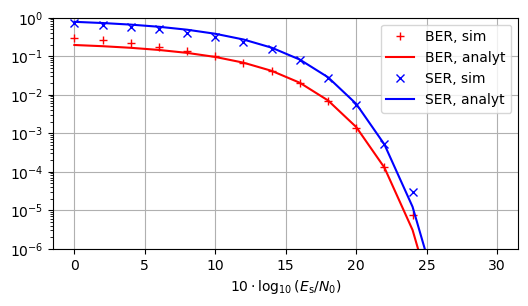

In [2]:
from scipy import special as sp

# analytical result
ser_analyt_psk = sp.erfc(np.sin(np.pi/M)*np.sqrt(SNR))
ber_analyt_psk = ser_analyt_psk / m

fig3 = plt.figure(figsize=(6,3))
ax3 = fig3.add_subplot(111)
ax3.semilogy(SNRdB, ber_psk, 'r+', label='BER, sim')
ax3.semilogy(SNRdB, ber_analyt_psk, 'r-', label='BER, analyt')
ax3.semilogy(SNRdB, ser_psk, 'bx', label='SER, sim')
ax3.semilogy(SNRdB, ser_analyt_psk, 'b-', label='SER, analyt')
plt.ylim(1e-6,1)
plt.xlabel('$10 \\cdot \\log_{10}(E_{\\mathrm{s}}/N_0)$')
plt.grid(True)
plt.legend()

Regarding the symbol error rate, a good agreement between the analytical solution and the Monte-Carlo simulation (markers) can be observed over the whole range of SNRs. Small deviations can be explained by the finite number of Monte-Carlo runs resulting in a limited accuracy. 

Furthermore, we can observe that the bit error rates are generally smaller than the symbol error rates. The reason is that not all bits need to be wrong in case of a wrong symbol detection. Some bits might still be correctly decided even though the wrong symbol has been chosen by the detector. Therefore, the bit error probability is lower than the symbol error probability. This holds particularly for medium and high SNRs. As error events are dominated by mixing up neighboring symbols with a small mutual distance to each other, Gray mapping has a smaller bit error probability than natural mapping. For Gray mapping, the bit error probability can be approximated by

\begin{equation}
    P_{\mathrm{b}} \approx \frac{P_{\mathrm{s}}}{m}
\end{equation}

with $P_{\mathrm{s}}$ denoting the symbol error probability. 

Also the simulated bit error rate nicely fits the analytic one. Only at very low SNRs, the analytic solution provides too small error probabilities. The reason is that at very low SNRs, if happens more often that not only direct neighbors but also symbols with large mutual distance are mixed up. This is not taken into account by the above approximation. Therefere, the approximation is too optimistic.

